# Matching

Exercises and examples from https://matheusfacure.github.io/python-causality-handbook/10-Matching.html

In [1]:
import pandas as pd

drug_example = pd.DataFrame(dict(
    sex= ["M","M","M","M","M","M", "W","W","W","W"],
    drug=[1,1,1,1,1,0,  1,0,1,0],
    days=[5,5,5,5,5,8,  2,4,2,4]
))

In [2]:
drug_example

,sex,drug,days
0,M,1,5
1,M,1,5
2,M,1,5
3,M,1,5
4,M,1,5
5,M,0,8
6,W,1,2
7,W,0,4
8,W,1,2
9,W,0,4


In [3]:
print("ATE", drug_example.query("drug==1")["days"].mean() - drug_example.query("drug==0")["days"].mean())

ATE -1.1904761904761898


Effect per gender

In [4]:
man_effect = drug_example.query("drug==1&sex=='M'")["days"].mean() - drug_example.query("drug==0&sex=='M'")["days"].mean()
woman_effect = drug_example.query("drug==1&sex=='W'")["days"].mean() - drug_example.query("drug==0&sex=='W'")["days"].mean()

print(f"man effect: {man_effect}")
print(f"woman effect: {woman_effect}")

man effect: -3.0
woman effect: -2.0


In [5]:
number_of_man    = drug_example[drug_example['sex'] == 'M'].shape[0]
number_of_woman  = drug_example[drug_example['sex'] == 'W'].shape[0]

print("# man", number_of_man)
print("# woman", number_of_woman)

# man 6
# woman 4


In [6]:
print("Since the true effect for men is -3 and the true effect for women is -2, the ATE should be")
print((man_effect*number_of_man + woman_effect*number_of_woman )/ (number_of_man+number_of_woman))

Since the true effect for men is -3 and the true effect for women is -2, the ATE should be
-2.6


However, when it comes to combining the effect on each group, it does not weigh them by the sample size. Instead, regression uses weights that are proportional to the variance of the treatment in that group. 

In [7]:
import statsmodels.formula.api as smf

smf.ols('days ~ drug + C(sex)', data=drug_example).fit().summary().tables[1]

/Users/ftobar/Documents/second-brain/second-brain-env/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.5455,0.188,40.093,0.000,7.100,7.990
C(sex)[T.W],-3.3182,0.176,-18.849,0.000,-3.734,-2.902
drug,-2.4545,0.188,-13.042,0.000,-2.900,-2.010


## Subclassification Estimator!

If there is some causal effect we want to estimate, like the effect of job training on earnings, and the treatment is not randomly assigned, we need to watch out for confounders

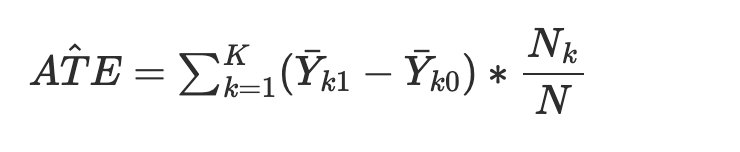

As you can see, we are computing a local ATE for each cell and combining them using a weighted average, where the weights are the sample size of the cell. In our medicine example above, this would be the first estimate, which gave us −2.6.

## Matching Estimator


As an example, let’s suppose we are trying to estimate the effect of a trainee program on earnings.

In [15]:
from pathlib import Path

data_path = ('../../data/causal_inference/trainees.csv')

trainee = pd.read_csv(data_path)
display(trainee.query("trainees==1") )
display(trainee.query("trainees==0"))

,unit,trainees,age,earnings
0,1,1,28,17700
1,2,1,34,10200
2,3,1,29,14400
3,4,1,25,20800
4,5,1,29,6100
5,6,1,23,28600
6,7,1,33,21900
7,8,1,27,28800
8,9,1,31,20300
9,10,1,26,28100


,unit,trainees,age,earnings
19,20,0,43,20900
20,21,0,50,31000
21,22,0,30,21000
22,23,0,27,9300
23,24,0,54,41100
24,25,0,48,29800
25,26,0,39,42000
26,27,0,28,8800
27,28,0,24,25500
28,29,0,33,15500


let's do a simple comparison

In [16]:
trainee.query("trainees==1")["earnings"].mean() - trainee.query("trainees==0")["earnings"].mean()

np.float64(-4297.49373433584)

However, if we look at the table above, we notice that trainees are much younger than non trainees, which indicates that age is probably a confounder. Let’s use matching on age to try to correct that. 

In [19]:
trainee.query("trainees==1")["age"].mean(), trainee.query("trainees==0")["age"].mean()

(np.float64(28.473684210526315), np.float64(33.0))

let's do a quick match based on age

In [20]:
# make dataset where no one has the same age
unique_on_age = (trainee
                 .query("trainees==0")
                 .drop_duplicates("age"))

matches = (trainee
           .query("trainees==1")
           .merge(unique_on_age, on="age", how="left", suffixes=("_t_1", "_t_0"))
           .assign(t1_minuts_t0 = lambda d: d["earnings_t_1"] - d["earnings_t_0"]))

matches.head(7)

,unit_t_1,trainees_t_1,age,earnings_t_1,unit_t_0,trainees_t_0,earnings_t_0,t1_minuts_t0
0,1,1,28,17700,27,0,8800,8900
1,2,1,34,10200,34,0,24200,-14000
2,3,1,29,14400,37,0,6200,8200
3,4,1,25,20800,35,0,23300,-2500
4,5,1,29,6100,37,0,6200,-100
5,6,1,23,28600,40,0,9500,19100
6,7,1,33,21900,29,0,15500,6400


In [21]:
matches["t1_minuts_t0"].mean()

np.float64(2457.8947368421054)

we usually have more than one feature and units don’t match perfectly.

One common metric for this is the euclidean norm. This difference, however, **is not invariant to the scale of the features**. This means that features like age, that take values on the tenths, will be much less important when computing this norm compared to features like income, which take the order of hundreds. For this reason, before applying the norm, we need to scale the features so that they are on roughly the same scale.

In [22]:
data_path = ('../../data/causal_inference/medicine_impact_recovery.csv')
med = pd.read_csv(data_path)

med.head()

,sex,age,severity,medication,recovery
0,0,35.049134,0.887658,1,31
1,1,41.580323,0.899784,1,49
2,1,28.127491,0.486349,0,38
3,1,36.375033,0.323091,0,35
4,0,25.091717,0.209006,0,15


In [23]:
med.query("medication==1")["recovery"].mean() - med.query("medication==0")["recovery"].mean()

np.float64(16.895799546498726)

In [26]:
# to do the match we are gonna scale the features

X = ['severity', 'age', 'sex']
y = 'recovery'

# this is norm scalling
med = med.assign(**{f: (med[f] - med[f].mean())/med[f].std() for f in X})

In [27]:
med

,sex,age,severity,medication,recovery
0,-0.996980,0.280787,1.459800,1,31
1,1.002979,0.865375,1.502164,1,49
2,1.002979,-0.338749,0.057796,0,38
3,1.002979,0.399465,-0.512557,0,35
4,-0.996980,-0.610473,-0.911125,0,15
...,...,...,...,...,...
19995,-0.996980,2.416531,0.635395,1,40
19996,1.002979,-1.568909,-1.389646,0,5
19997,-0.996980,1.438855,-0.133945,0,37
19998,-0.996980,-0.365872,-1.354389,0,6


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

treated   = med.query("medication==1")
untreated = med.query("medication==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[X], untreated[y])
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[X], treated[y])

This algorithm makes predictions by finding the nearest data point in an estimation or training set.

In [33]:
treated.shape, untreated.shape

((6924, 5), (13076, 5))

In [56]:
predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated.assign(match=mt0.predict(treated[X])),

    # find matches for the untreated looking at the treated knn model
    untreated.assign(match=mt1.predict(untreated[X]))
])

predicted.head()

,sex,age,severity,medication,recovery,match
0,-0.996980,0.280787,1.459800,1,31,39.0
1,1.002979,0.865375,1.502164,1,49,52.0
7,-0.996980,1.495134,1.268540,1,38,46.0
10,1.002979,-0.106534,0.545911,1,34,45.0
16,-0.996980,0.043034,1.428732,1,30,39.0


In [58]:
import numpy as np
print(np.mean((2*predicted["medication"] - 1)*(predicted["recovery"] - predicted["match"])))

-0.9954


## Bias

Bias arises when the matching discrepancies are huge.  Fortunately, we know how to correct it. Each observation contributes to the bias so all we need to do is subtract this quantity from each matching comparison in our estimator.

In [ ]:
from sklearn.linear_model import LinearRegression

# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(untreated[X], untreated[y])
ols1 = LinearRegression().fit(treated[X], treated[y])

# find the units that match to the treated
treated_match_index = mt0.kneighbors(treated[X], n_neighbors=1)[1].ravel()

# find the units that match to the untreatd
untreated_match_index = mt1.kneighbors(untreated[X], n_neighbors=1)[1].ravel()

predicted = pd.concat([
    (treated
     # find the Y match on the other group
     .assign(match=mt0.predict(treated[X]))

     # build the bias correction term
     .assign(bias_correct=ols0.predict(treated[X]) - ols0.predict(untreated.iloc[treated_match_index][X]))),
    (untreated
     .assign(match=mt1.predict(untreated[X]))
     .assign(bias_correct=ols1.predict(untreated[X]) - ols1.predict(treated.iloc[untreated_match_index][X])))
])

predicted.head()

,sex,age,severity,medication,recovery,match,bias_correct
0,-0.996980,0.280787,1.459800,1,31,39.0,4.404034
1,1.002979,0.865375,1.502164,1,49,52.0,12.915348
7,-0.996980,1.495134,1.268540,1,38,46.0,1.871428
10,1.002979,-0.106534,0.545911,1,34,45.0,-0.496970
16,-0.996980,0.043034,1.428732,1,30,39.0,2.610159


In [66]:
np.mean((2*predicted["medication"] - 1)*((predicted["recovery"] - predicted["match"])-predicted["bias_correct"]))

np.float64(-7.362660906141414)

In [68]:
from causalinference import CausalModel

cm = CausalModel(
    Y=med["recovery"].values,
    D=med["medication"].values,
    X=med[["severity", "age", "sex"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -7.709      0.609    -12.649      0.000     -8.903     -6.514
           ATC     -6.665      0.246    -27.047      0.000     -7.148     -6.182
           ATT     -9.679      1.693     -5.717      0.000    -12.997     -6.361



## Dimensionality
In more general terms, the more features we have, the higher will be the distance between units and their matches. So, in some way, linear regression performs some sort of dimensionality reduction to estimate the ATE. It’s quite elegant.